In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv("/home/lola/ai_intrusion_detection_system/data/raw/cybersecurity_intrusion_data.csv")

df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [2]:
df.drop('session_id', axis = 1, inplace=True)  # preprocessing step

In [3]:
print('Shape of data:', df.shape)
print('Data Types:\n', df.dtypes)
print('\nMissing Values:\n', df.isnull().sum())
print('Duplicated Lines:', df.duplicated().sum())

Shape of data: (9537, 10)
Data Types:
 network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

Missing Values:
 network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64
Duplicated Lines: 0


In [4]:
df['encryption_used'] = df['encryption_used'].fillna('None')  # preprocessing step

/tmp/ipykernel_781814/2742943137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette='Set2')
/tmp/ipykernel_781814/2742943137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette='Set2')
/tmp/ipykernel_781814/2742943137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=col, data=df, palette='Set2')
/tmp/ipykernel_781814/2742943137.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue

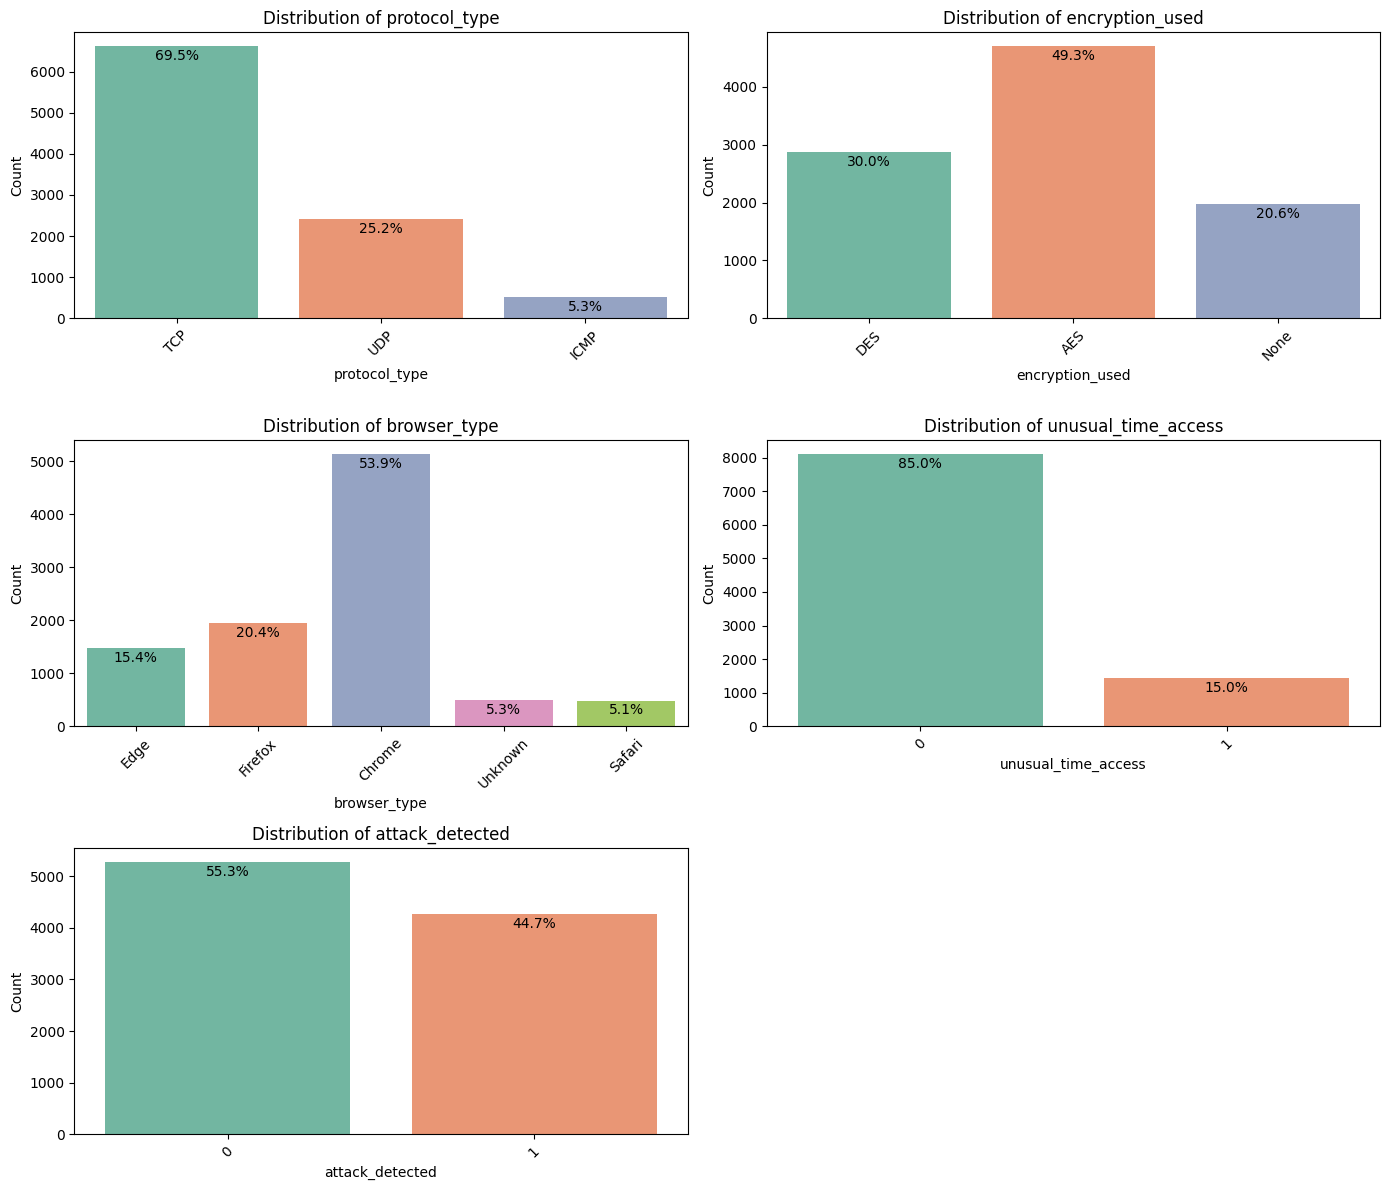

In [5]:
categorical_and_binary_cols = ['protocol_type', 'encryption_used', 'browser_type', 'unusual_time_access', 'attack_detected']
num_cols = 2
num_rows = (len(categorical_and_binary_cols) + num_cols - 1) // num_cols
plt.figure(figsize=(14, num_rows * 4))

for i, col in enumerate(categorical_and_binary_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    ax = sns.countplot(x=col, data=df, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    
    total = len(df)
    for p in ax.patches:
        count = p.get_height()
        percent = 100 * count / total
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        offset = 0.01 * ax.get_ylim()[1]
        ax.annotate(f'{percent:.1f}%', (x, y - offset), ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.show()

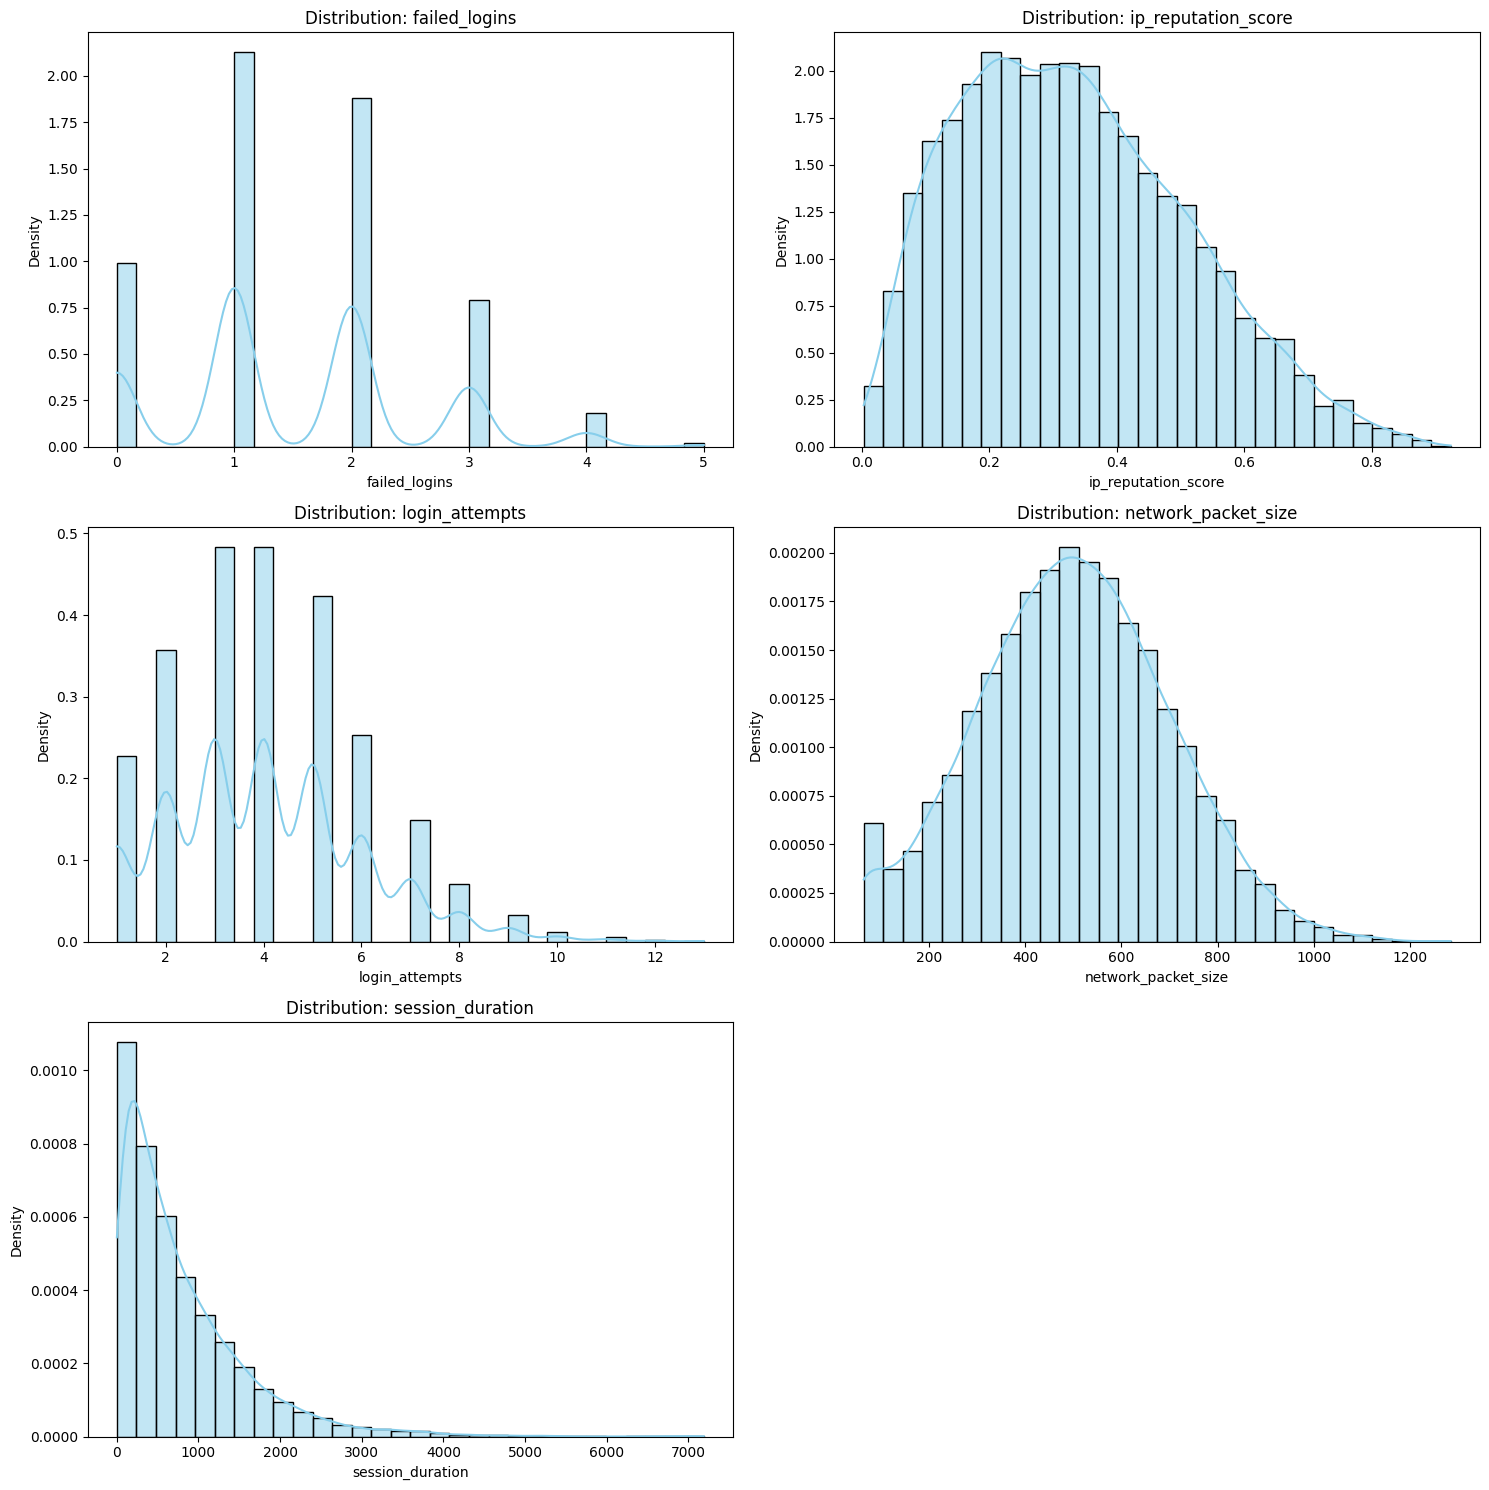

In [6]:
binary_cols = ['unusual_time_access', 'attack_detected']
numeric_cols = df.select_dtypes(include=[np.number]).columns.difference(binary_cols)

num_cols = 2
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols 
plt.figure(figsize=(15, num_rows * 5))

for i, column in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, num_cols, i) 
    sns.histplot(df[column], kde=True, stat='density', color='skyblue', bins=30)
    plt.title(f"Distribution: {column}")
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

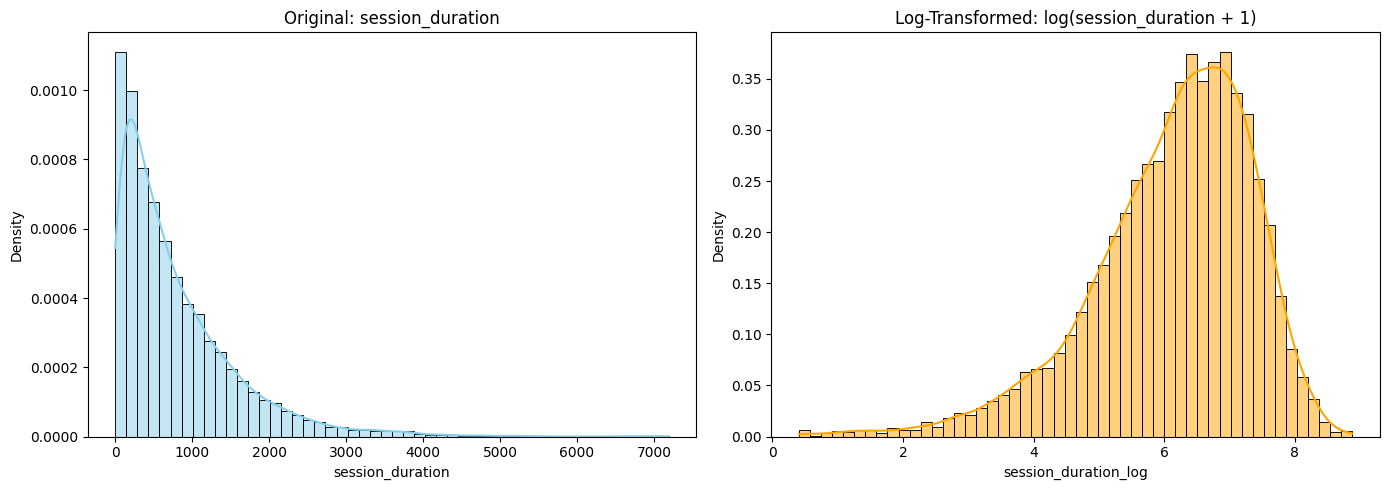

In [7]:
df_plot = df.copy()
df_plot['session_duration_log'] = np.log1p(df_plot['session_duration'])  # preprocessing step

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_plot['session_duration'], bins=50, stat='density', kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Original: session_duration')
axes[0].set_xlabel('session_duration')
axes[0].set_ylabel('Density')


sns.histplot(df_plot['session_duration_log'], bins=50, stat='density', kde=True, color='orange', ax=axes[1])
axes[1].set_title('Log-Transformed: log(session_duration + 1)')
axes[1].set_xlabel('session_duration_log')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import zscore

z_scores = np.abs(zscore(df[numeric_cols]))
outliers = (z_scores > 3).any(axis=1)
print(f"{outliers.sum()} potential Outliers")

317 potential Outliers


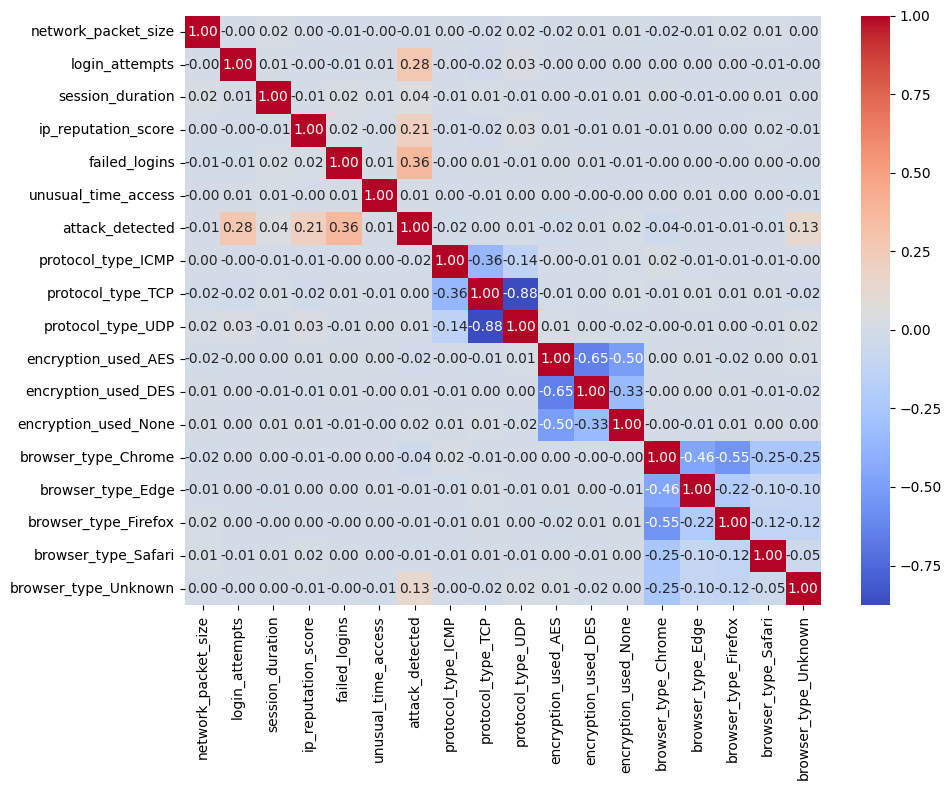

In [9]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df_corrplot = pd.get_dummies(df.copy(), columns=categorical_cols, drop_first=False)


plt.figure(figsize=(10, 8))
sns.heatmap(df_corrplot.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.tight_layout()
plt.show()

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_encoded = pd.get_dummies(df.copy(), columns=categorical_cols, drop_first=True)  #preprocessing step

X = df_encoded.drop('attack_detected', axis=1).astype(float)
X = add_constant(X)

vif = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

print(vif.sort_values(ascending=False))

const                   37.545205
protocol_type_UDP        4.301456
protocol_type_TCP        4.299513
encryption_used_None     1.126643
encryption_used_DES      1.126440
browser_type_Firefox     1.098446
browser_type_Edge        1.088547
browser_type_Unknown     1.040962
browser_type_Safari      1.039707
ip_reputation_score      1.001808
network_packet_size      1.001793
session_duration         1.001606
failed_logins            1.001248
login_attempts           1.001088
unusual_time_access      1.000571
dtype: float64


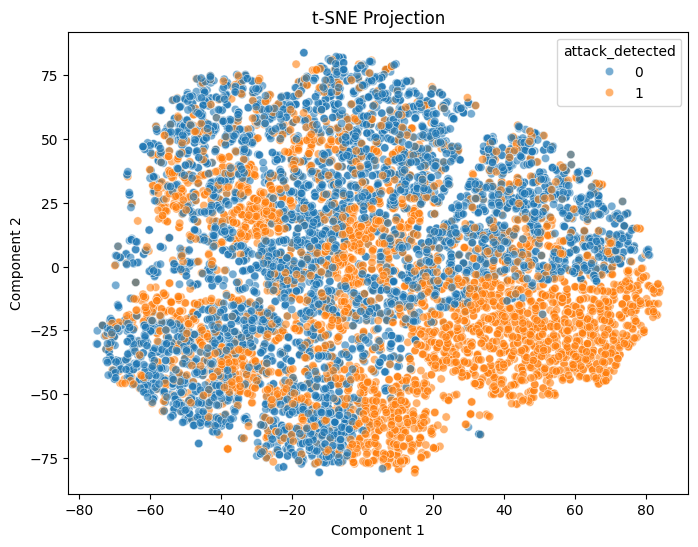

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

df_encoded['session_duration_log'] = np.log1p(df_encoded['session_duration'])
df_encoded.drop('session_duration', axis=1, inplace=True)

scaler = StandardScaler()
numerical_cols = ['network_packet_size', 'login_attempts', 'ip_reputation_score', 'failed_logins', 'session_duration_log']
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

X = df_encoded.drop('attack_detected', axis=1)
y = df_encoded['attack_detected']

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_embedded[:, 0], 
    y=X_embedded[:, 1], 
    hue=y, 
    palette={0: '#1f77b4', 1: '#ff7f0e'}, 
    alpha=0.6
)
plt.title('t-SNE Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
